Després de veure els resultats dels models sense features, ara toca experimentar amb quins features i quina codificació fan que el model millori.
En aquesta versió, afegim embeddings de paraules utilitzant Word2Vec per obtenir un millor context semàntic.

In [ ]:
#%pip install gensim

In [1]:
import nltk
import re
import unicodedata
import numpy as np
from nltk.tag import CRFTagger
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report

nltk.download('conll2002')
nltk.download('stopwords')
from nltk.corpus import conll2002, stopwords

tr_ne = conll2002.iob_sents('ned.train') # Train Neerlandés
dev_ne = conll2002.iob_sents('ned.testa') # Dev Neerlandés
test_ne = conll2002.iob_sents('ned.testb') # Test Neerlandés

stop_words = set(stopwords.words('dutch'))

# Cargar el modelo de embeddings, aquí usamos Word2Vec preentrenado
print("Cargando modelo de Word2Vec...")
word2vec_model = KeyedVectors.load_word2vec_format('model_ned.bin', binary=True) 
print("Modelo cargado correctamente!")

[nltk_data] Downloading package conll2002 to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2002 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\34644\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cargando modelo de Word2Vec...
Modelo cargado correctamente!


In [ ]:
# Transformar los datos: dejar solo (palabra, NER)
train_sents = [[(word, ner) for word, pos, ner in sent] for sent in tr_ne]
dev_sents = [[(word, ner) for word, pos, ner in sent] for sent in dev_ne]
test_sents = [[(word, ner) for word, pos, ner in sent] for sent in test_ne]

In [4]:
def features(tokens, idx):
    """
    Extrae características de una palabra, incluyendo:
        - Capitalización
        - Prefijos y sufijos
        - Tokens anteriores y posteriores
        - Embedding de palabra utilizando Word2Vec
    """
    pattern = re.compile(r"\d")
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list

    # Capitalización
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Número
    if re.search(pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Puntuación
    punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Prefijos y sufijos
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
        feature_list.append("PREF_" + token[:1])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
        feature_list.append("PREF_" + token[:2])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        feature_list.append("PREF_" + token[:3])

    # Palabra anterior
    if idx > 0:
        prev_token = tokens[idx - 1]
        feature_list.append("PREV_WORD_" + prev_token)
    else:
        feature_list.append("BOS")  # Inicio de oración

    # Palabra siguiente
    if idx < len(tokens) - 1:
        next_token = tokens[idx + 1]
        feature_list.append("NEXT_WORD_" + next_token)
    else:
        feature_list.append("EOS")  # Fin de oración

    # Embedding de palabra utilizando Word2Vec
    try:
        embedding_vector = word2vec_model[token.lower()]
        # Añadimos los primeros 10 valores del embedding como características
        for i, value in enumerate(embedding_vector[:10]):
            feature_list.append(f"EMBEDDING_DIM_{i}_{value:.4f}")
    except KeyError:
        feature_list.append("UNK_EMBEDDING")  # Palabra desconocida
    
    

    feature_list.append("WORD_" + token)

    return feature_list

In [5]:
ct = nltk.tag.CRFTagger(feature_func=features)
ct.train(train_sents, 'ned_model.crf.tagger')
ct.set_model_file('ned_model.crf.tagger')

In [6]:
predicted_sents = ct.tag_sents([ [word for word, tag in sent] for sent in test_sents ])
print(sum(len(s) for s in predicted_sents))

68875


In [ ]:
# F1-Score a nivel de entidades
from sklearn.metrics import classification_report

true_entities = []
predicted_entities = []

for true_sent, pred_sent in zip(test_sents, predicted_sents):
    for (word_t, tag_t), (word_p, tag_p) in zip(true_sent, pred_sent):
        if tag_t != 'O':  # <- Aquí filtrem les paraules que són entitats en el conjunt de test
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)
        elif tag_p != 'O' and tag_t == 'O': # <- Tmb agafem les entitats que el model prediu com entitats pero no ho són.
            true_entities.append(tag_t)
            predicted_entities.append(tag_p)

# Generar informe de clasificación
print("Classification Report:")
print(classification_report(true_entities, predicted_entities, digits=4))
print(len(true_entities))

Classification Report:
              precision    recall  f1-score   support

       B-LOC     0.8565    0.7636    0.8074       774
      B-MISC     0.8497    0.7001    0.7677      1187
       B-ORG     0.8064    0.6610    0.7265       882
       B-PER     0.7474    0.8434    0.7925      1098
       I-LOC     0.8125    0.5306    0.6420        49
      I-MISC     0.4701    0.4220    0.4447       410
       I-ORG     0.6426    0.6298    0.6361       551
       I-PER     0.8330    0.9579    0.8911       807
           O     0.0000    0.0000    0.0000       186

    accuracy                         0.7150      5944
   macro avg     0.6687    0.6120    0.6342      5944
weighted avg     0.7507    0.7150    0.7285      5944

5944


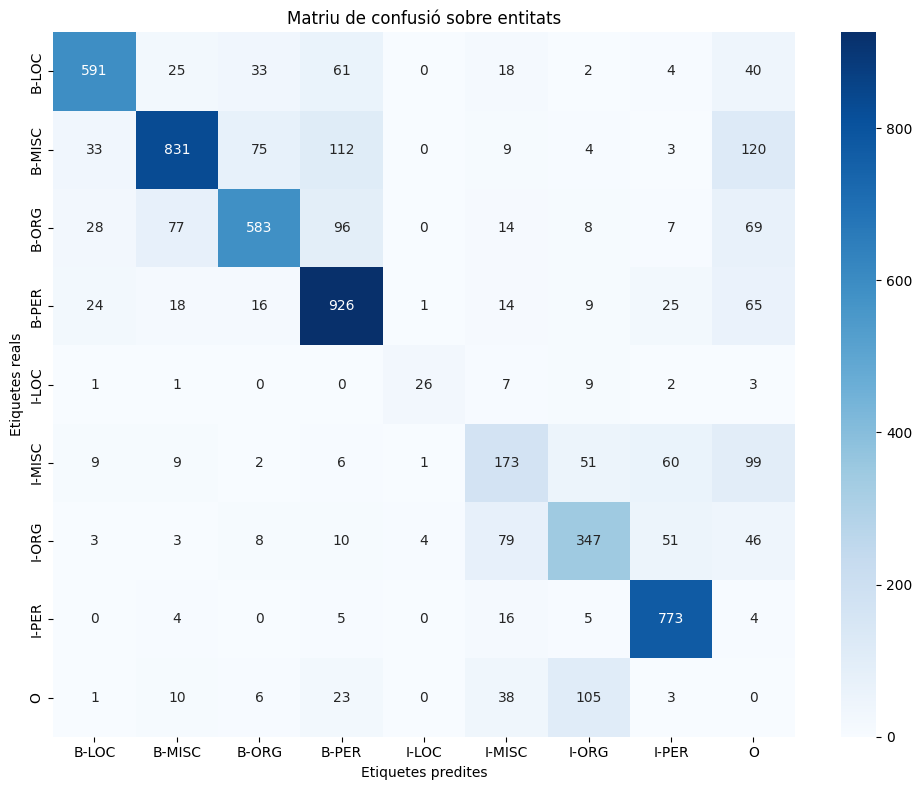

In [8]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

labels = sorted(set(true_entities + predicted_entities))

cm = confusion_matrix(true_entities, predicted_entities, labels=labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Etiquetes predites')
plt.ylabel('Etiquetes reals')
plt.title('Matriu de confusió sobre entitats')
plt.tight_layout()
plt.show()

In [28]:
from collections import Counter
import pandas as pd

# Aplanem les etiquetes del conjunt de train
test_tags = [tag for sentence in test_sents for (_, tag) in sentence]

# Comptem les ocurrències de cada etiqueta
tag_counts = Counter(test_tags)

# Convertim a DataFrame i ordenem per freqüència
df_test_entities = pd.DataFrame(tag_counts.items(), columns=['Etiqueta', 'Freqüència'])
df_test_entities = df_test_entities.sort_values(by='Freqüència', ascending=False).reset_index(drop=True)

print(df_test_entities)

  Etiqueta  Freqüència
0        O       63117
1   B-MISC        1187
2    B-PER        1098
3    B-ORG         882
4    I-PER         807
5    B-LOC         774
6    I-ORG         551
7   I-MISC         410
8    I-LOC          49


In [29]:
# Aplanem les etiquetes del conjunt de train
train_tags = [tag for sentence in train_sents for (_, tag) in sentence]

# Comptem les ocurrències de cada etiqueta
tag_counts = Counter(train_tags)

# Convertim a DataFrame i ordenem per freqüència
df_train_entities = pd.DataFrame(tag_counts.items(), columns=['Etiqueta', 'Freqüència'])
df_train_entities = df_train_entities.sort_values(by='Freqüència', ascending=False).reset_index(drop=True)

print(df_train_entities)

  Etiqueta  Freqüència
0        O      183346
1    B-PER        4716
2   B-MISC        3338
3    B-LOC        3208
4    I-PER        2883
5    B-ORG        2082
6   I-MISC        1405
7    I-ORG        1199
8    I-LOC         467
